In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

class Column:
    epoch = 'epoch'
    eval_0	 = 'eval_0'
    eval_1	 = 'eval_1'
    eval = 'eval'
    ALGORITHM = 'Algorithm'

class Algorithm:
    Direct = 'Direct CT-FHADP'
    Indirect = 'Indirect CT-FHADP'

class Criterion:
    LOSS = 'loss/train'
    EVAL_0 = 'loss/eval_0'
    EVAL_1 = 'loss/eval_1'

class Env:
    TRACKING = 'tracking'

c1 = (220 / 255, 0, 0)
c2 = (158 / 255, 10 / 255, 210 / 255)
c3 = (20 / 255, 101 / 255, 200 / 255)
c4 = (0 / 255, 128 / 255, 0 / 255)
color1 = c4
color2 = c2

algorithm_to_color = {
    Algorithm.Direct: color1,
    Algorithm.Indirect: color2,
}

algorithm_to_ratio = {
    Algorithm.Direct: 1,
    Algorithm.Indirect: 500,
}

In [2]:
import pickle
def read_df_data(path):
    with open(path+'/df.pkl', 'rb') as handle:
        df = pickle.load(handle)
    return df

In [3]:
def load_data(path, alg):
    if alg == 'Direct CT-FHADP':
        start, end = 100, 2000
    else:
        start, end = 100, 2000
    data = {alg: []}
    x_ratio = algorithm_to_ratio[alg]
    alg_path = os.path.join(path, alg)
    ## different seeds
    filenames = os.listdir(alg_path)
    for filename in filenames:
        df = read_df_data(os.path.join(alg_path, filename))
        
        ## interpolation
        new_step = np.linspace(int(start), int(end), 200)
        new_value = np.interp(new_step, df[Column.epoch]/x_ratio, df[Column.eval_0]+df[Column.eval_1])
        df = pd.DataFrame({Column.epoch: new_step, Column.eval: new_value})

        ## smooth
        df[Column.eval] = smooth(df[Column.eval])
        df.insert(loc=len(df.columns), column=Column.ALGORITHM, value=alg)

        ## save as a dict temporally
        data[alg].append(df)

    ## concat as a dataframe
    dfs = []
    for df in data.values():
        dfs.extend(df)
    data = pd.concat(dfs).reset_index()
    return data

def smooth(x, width=2):
    y = np.ones(width)
    z = np.ones(len(x))
    return np.convolve(x, y, 'same') / np.convolve(z, y, 'same')

<Axes.ArtistList of 3 lines>


/tmp/ipykernel_3024263/1421367031.py:45: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim([0, 1000])


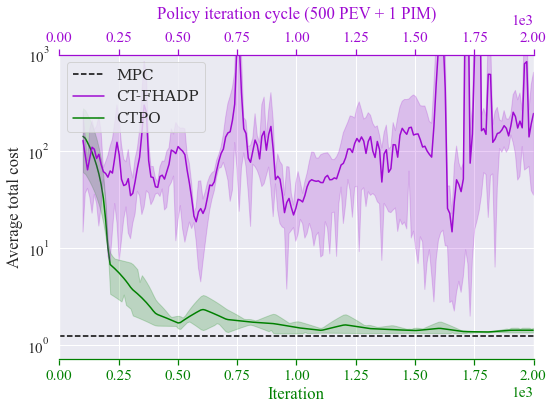

In [5]:
plt.rcParams['font.size'] = 25.2
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
env = Env.TRACKING
criterions = [Criterion.EVAL_0, Criterion.EVAL_1]
algorithms = [Algorithm.Direct, Algorithm.Indirect]

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twiny()

data1 = load_data('logs', algorithms[0])
data2 = load_data('logs', algorithms[1])
sns.set_theme(style="dark", font_scale=1.4, font='serif')
legend=False
sns.lineplot(ax=ax1, data=data1, x=Column.epoch, y=Column.eval, hue=Column.ALGORITHM, ci=95,
                palette=algorithm_to_color)
sns.lineplot(ax=ax2, data=data2, x=Column.epoch, y=Column.eval, hue=Column.ALGORITHM, ci=95,
                palette=algorithm_to_color)
sns.lineplot(ax=ax1, x=[0, 20000], y=[1.2369+0.0099, 1.2369+0.0099], color='black', linestyle='--')
plt.yscale('log')
ax1.legend_.remove()
ax2.legend_.remove()
print(ax1.lines)
ax2.legend(handles=[ax1.lines[2], ax2.lines[0], ax1.lines[0]],
           labels=["MPC", "CT-FHADP", "CTPO"],
           loc='upper left')


# plt.xlim(data1[Column.STEP].min(), data1[Column.STEP].max())
ax1.set_xlabel('Iteration')
ax2.set_xlabel('Policy iteration cycle (500 PEV + 1 PIM)', labelpad = 12)
ax1.set_ylabel('Average total cost')


ax2.spines['bottom'].set_color(color1)
ax1.tick_params(axis='x', colors=color1, which='both')
ax1.xaxis.label.set_color(color1)

ax2.spines['top'].set_color(color2) 
ax2.tick_params(axis='x', colors=color2, which='both')
ax2.xaxis.label.set_color(color2)

ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 1000])
ax2.set_xlim([0, 2000])

ax1.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
_ = ax1.grid(which='major', axis='x', zorder=2.0)
_ = ax1.grid(which='major', axis='y', zorder=2.0)

plt.tight_layout()
plt.savefig(f'figures/eval_curve_cost.pdf')